# Capstone project 

##### Project: Residential apartment development locational choice 

## Section A: Introduction / Business Problem

This is a project commissioned by a real estate developer who is looking to build an apartment block in the Greater London area. 
The main target buyers of these apartments are families with working parents who are still keen to live in the city, but would like to be in locations with close proximity to schools for their young kids.
Areas with more choices for different types of schools are typically preferred by parents (public vs. private).
Also it would be preferrable if these areas offer school options for young as well as older kids (i.e. primary to high schools).

#### Import libraries

In [1]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import itertools

from geopy.geocoders import Nominatim
import folium

import matplotlib.pyplot as plt
from matplotlib import cm, colors

print("All libraries are successfully imported!")

All libraries are successfully imported!


## Section B: Data

Three data sources in this project:

- All postal areas in Greater London (name of the postal area and its postcodes). Data source: www.worldpostalcode.com

- Geo-coordinates of postal areas in London (latitude and longitudes). Data source: Geopy

- List of school venues in London and its type (e.g. venue category). Data source: Foursquare API

## Section C: Methodology / Exploratory data analysis

Note: this section also include codes to fetch data from data sources mentioned in the Data section.

### Extract postcodes in Greater London

Data source: www.worldpostalcode.com

In [2]:
url = "https://worldpostalcode.com/united-kingdom/england/greater-london"
html = requests.get(url).text
soup = BeautifulSoup(html)
bs = BeautifulSoup(html).prettify()

In [4]:
# extract place names
place_names = []
for item in soup.find_all('div', class_='place'):
    place_names.append(item.get_text())

In [5]:
place_names[:10]

['Abbey Road',
 'Abbey Wood',
 'Acton',
 'Acton Green',
 'Acton Town',
 'Addington',
 'Aldersbrook',
 'Aldersgate',
 'Aldgate',
 'Aldgate East']

In [6]:
# extract postcodes
place_codes = []
for item in soup.find_all('div', class_='code'):
    place_codes.append(item.get_text())

In [7]:
place_codes[:10]

['NW8', 'SE2', 'W3', 'W4', 'W5', 'CR0', 'E12', 'EC1', 'EC3', 'E1']

In [8]:
# create a dataframe
data = {'PostCode':place_codes, 'Areas':place_names}
london_areas = pd.DataFrame(data, columns=data.keys())

In [9]:
london_areas.head()

,PostCode,Areas
0,NW8,Abbey Road
1,SE2,Abbey Wood
2,W3,Acton
3,W4,Acton Green
4,W5,Acton Town


In [10]:
print("{} postcodes in Greater London retrieved.".format(london_areas.shape[0]))

720 postcodes in Greater London retrieved.


### Getting Geo Coordinates of each area

Data source: Geopy

In [11]:
# finding the latitude and longitude of all postal areas of G.London
geolocator = Nominatim(user_agent = 'g_london')

# create two empty lists for lat and lng data
latitude = []
longitude = []

place = 'London'

# loop over the dataset to find geo coords for each postal code
for row in london_areas.iterrows():
    address = '%s,%s'%(row[1][1],place)
    location = geolocator.geocode(address)
    # append 0 to the list if results not found
    try:
        latitude.append(location.latitude)
        longitude.append(location.longitude)
    except:
        latitude.append(0)
        longitude.append(0)

In [12]:
# add lat and long to the london_areas dataframe
london_areas['Lat'] = latitude
london_areas['Lng'] = longitude

# find out rows with zero lat and long
london_areas[london_areas.Lat==0]

,PostCode,Areas,Lat,Lng
89,RM14,Bulphan,0.0,0.0
91,SW20,Bushey Mead,0.0,0.0
104,SW13,Castlenau,0.0,0.0
380,E10,Leyton Marshes,0.0,0.0
526,HA6,Ruislip Common,0.0,0.0


In [13]:
type(london_areas)

pandas.core.frame.DataFrame

In [14]:
# remove those without no coords
london_areas.dropna()

print('Shape after dropping:', london_areas.shape)

Shape after dropping: (720, 4)


In [15]:
london_areas.head()

,PostCode,Areas,Lat,Lng
0,NW8,Abbey Road,51.458009,0.134958
1,SE2,Abbey Wood,51.487621,0.114050
2,W3,Acton,51.508140,-0.273261
3,W4,Acton Green,51.496080,-0.264280
4,W5,Acton Town,51.502705,-0.279964


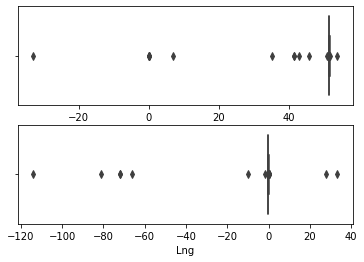

In [16]:
# check if there are outliers
import seaborn as sns

fig, ax = plt.subplots(2,1)
sns.boxplot(x=london_areas['Lat'], ax=ax[0])
sns.boxplot(x=london_areas['Lng'], ax=ax[1])
plt.show()

In [17]:
# remove outliers

Q1 = london_areas.quantile(0.25)
Q3 = london_areas.quantile(0.75)
IQR = Q3-Q1

london_areas = london_areas[~((london_areas<(Q1-1.5*IQR)) | (london_areas>(Q3+1.5*IQR))).any(axis=1)]

In [18]:
print('Shape after dropping outliers:', london_areas.shape)

Shape after dropping outliers: (680, 4)


##### Visualise areas in Greater London 

In [19]:
# create a map of Greater London with areas superimposed

import folium

latitude = london_areas.Lat.mean()
longitude = london_areas.Lng.mean()

map_london = folium.Map(location=[latitude,longitude],zoom_start=10)

for lat, lng, area in zip(london_areas.Lat, london_areas.Lng, london_areas.Areas):
    label = '{}'.format(area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup=label,
        fill=True,
        fill_color='#3186cc',
        fill_opaciy=0.7,
        parse_html=False).add_to(map_london)

map_london

### Explore areas with Foursquare API

Data source: Foursquare

In [20]:
CLIENT_ID = 'CLIENT_ID_HIDDEN'
CLIENT_SECRET = 'CLIENT_SECRET_HIDDEN'
REDIRECT_URL = 'https://www.ibm_capstone_project.com/redirect_uri'
VERSION = '20191208'
LIMIT = 100
RADIUS = 500

##### Get schools in each area

In [94]:
School_check = []
School_name = []
School_category = []
Lat = []
Lng = []

def school_finder(lat, lng):
    query = 'school'
    for lat, lng in zip(lat, lng):
        local_school = []
        school_category = []
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&query={}'.format(
                CLIENT_ID,
                CLIENT_SECRET,
                VERSION,
                lat,
                lng,
                RADIUS,
                query)
        result = requests.get(url).json()['response']['venues']
        for i in range(len(result)):
            local_school.append(result[i]['name'])
            try:
                school_category.append(result[i]['categories'][0]['name'])
            except:
                school_category.append(0)
        if len(local_school) == 0:
            School_check.append(0)
        else:
            School_check.append(1)
        School_name.append(local_school)
        School_category.append(school_category)
        Lat.append(lat)
        Lng.append(lng)

In [95]:
school_finder(london_areas.Lat, london_areas.Lng)

In [101]:
# add data back to the dataframe and display the first few rows
london_areas['School_check'] = School_check
london_areas['School_name'] = School_name
london_areas['School_category'] = School_category
london_areas.head()

,PostCode,Areas,Lat,Lng,School_check,School_name,School_category
0,NW8,Abbey Road,51.458009,0.134958,1,"[Top dog Training School & Home Boarding, Upla...","[Pet Service, School, Elementary School]"
1,SE2,Abbey Wood,51.487621,0.114050,1,"[Abbeywood Nursury School & Children's Centre,...","[Nursery School, Middle School, Driving School..."
2,W3,Acton,51.508140,-0.273261,1,"[Aim Driving School, Aim Driving School, Acton...","[Driving School, Driving School, Music School,..."
3,W4,Acton Green,51.496080,-0.264280,1,"[Belmont Primary School, Belmont Primary Schoo...","[School, Elementary School, Trade School, School]"
4,W5,Acton Town,51.502705,-0.279964,1,"[Kid's Cookery School, Mill Hill School, Bloss...","[0, 0, 0, High School, College Academic Buildi..."


In [246]:
print('Among {} postal areas in Greater London. There are {} areas without any school in the area.'.format(london_areas.shape[0],sum(london_areas.School_check == 0)))

Among 680 postal areas in Greater London. There are 99 areas without any school in the area.


In [103]:
areas_without_school = london_areas[london_areas['School_check']==0].Areas.to_list()
areas_without_school[:10]

['Addington',
 'Aldersbrook',
 'Alexandra Palace',
 'Arkley',
 'Barkingside',
 'Beddington Corner',
 'Belmont',
 'Belvedere',
 'Bexley',
 'Botany Bay']

In [121]:
# copy the london_areas dataframe to london_df to protect raw data from API
london_df = london_areas

##### Cluster the areas based on Lat and Lng

There are areas where there are no schools at all. But this is could be ok if there schools nearby, i.e. areas in the same cluster. So we will cluster areas based on Lat and Lng.

But before we cluster, first check the optimum number of clusters to use.

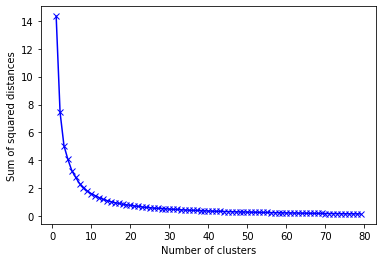

In [122]:
from sklearn.cluster import KMeans

# group the lat and lng
data_clustered = london_df[['Lat','Lng']]

# find optimum k
Ks = range(1,80)
ssq_dis = []

for k in Ks:
    km = KMeans(n_clusters=k).fit(data_clustered)
    ssq_dis.append(km.inertia_)
    
plt.plot(Ks, ssq_dis, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.show()

30 clusters appear to be a good optimum point as any further increases in clusters yield little reduction in error.

In [128]:
k = 30
kmeans = KMeans(n_clusters=k).fit(data_clustered)

# store cluster labels and centres 
kmeans_labels = kmeans.labels_
kmeans_cluster_centres = kmeans.cluster_centers_

# add cluster numbers back to the london_areas dataframe
london_df['clusters'] = kmeans_labels

# review the dataframe
london_df.head()

,PostCode,Areas,Lat,Lng,School_check,School_name,School_category,clusters
0,NW8,Abbey Road,51.458009,0.134958,1,"[Top dog Training School & Home Boarding, Upla...","[Pet Service, School, Elementary School]",5
1,SE2,Abbey Wood,51.487621,0.114050,1,"[Abbeywood Nursury School & Children's Centre,...","[Nursery School, Middle School, Driving School...",5
2,W3,Acton,51.508140,-0.273261,1,"[Aim Driving School, Aim Driving School, Acton...","[Driving School, Driving School, Music School,...",15
3,W4,Acton Green,51.496080,-0.264280,1,"[Belmont Primary School, Belmont Primary Schoo...","[School, Elementary School, Trade School, School]",15
4,W5,Acton Town,51.502705,-0.279964,1,"[Kid's Cookery School, Mill Hill School, Bloss...","[0, 0, 0, High School, College Academic Buildi...",15


##### Visualise the clustered areas in London

In [182]:
map_london_clusters = folium.Map(location=[latitude,longitude], zoom_start=10)

# format colour for each cluster
x = np.arange(k)
ys = [i+x+(i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0,1,len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers
for lat, lng, area, cluster in zip(london_df.Lat, london_df.Lng, london_df.Areas, london_df.clusters):
    label = '{}, cluster {}'.format(area, cluster)
    label = folium.Popup(label, parse_html=True)
    folium.features.CircleMarker(
        [lat,lng],
        radius = 5,
        color = rainbow[cluster-1],
        fill = True,
        popup = label,
        fill_color = rainbow[cluster-1],
        fill_opacity = 0.6,
        parse_html=False
    ).add_to(map_london_clusters)
    
map_london_clusters

### Further data cleaning

Data source: Foursquare

Unpack the School_name and School_category cols in the london_df dataframe 

In [132]:
london_df_unpacked = pd.concat([pd.DataFrame(dict(zip(london_df.columns,london_df.iloc[i]))) for i in range(len(london_df))])

In [137]:
london_unpacked = london_df_unpacked.reset_index(drop=True)
london_unpacked

,PostCode,Areas,Lat,Lng,School_check,School_name,School_category,clusters
0,NW8,Abbey Road,51.458009,0.134958,1,Top dog Training School & Home Boarding,Pet Service,5
1,NW8,Abbey Road,51.458009,0.134958,1,Uplands Primary School,School,5
2,NW8,Abbey Road,51.458009,0.134958,1,Crook Log Primary School,Elementary School,5
3,SE2,Abbey Wood,51.487621,0.114050,1,Abbeywood Nursury School & Children's Centre,Nursery School,5
4,SE2,Abbey Wood,51.487621,0.114050,1,Alexander Mcleod Primary School,Middle School,5
...,...,...,...,...,...,...,...,...
3394,EN5,Wrotham Park,51.469085,0.120802,1,Brampton Primary School,Elementary School,5
3395,EN5,Wrotham Park,51.469085,0.120802,1,Welling School,School,5
3396,EN5,Wrotham Park,51.469085,0.120802,1,Foster's Primary School,School,5
3397,UB4,Yeading,51.527239,-0.399270,1,The School,Sorority House,21


There are 3399 rows of schools returned. But they are not all relevant.

1) Remove irrelevant schools, e.g. Pet Services

2) Remove universities / colleges because you don't need to live in the area to be enrolled into an university

In [247]:
# find out venue types of all schools returned - some of these are not actually schools
london_unpacked.School_category.unique()

array(['Pet Service', 'School', 'Elementary School', 'Nursery School',
       'Middle School', 'Driving School', 'Music School', 'High School',
       'College Classroom', 'Trade School', 0,
       'College Academic Building', 'Salon / Barbershop', 'Office',
       'University', 'Concert Hall', 'General College & University',
       'College Arts Building', 'Wine Bar', 'Religious School',
       'Law School', 'Language School', 'Cosmetics Shop',
       'Cooking School', 'College Residence Hall', 'Tech Startup',
       'College Auditorium', 'College Administrative Building',
       'College Library', 'Dance Studio', 'College Cafeteria',
       'Student Center', 'Adult Education Center',
       'College Science Building', 'Farmers Market', 'Camera Store',
       'Art Studio', 'Business Service', 'Food Stand', 'Clothing Store',
       'College Gym', 'Building', 'Mobile Phone Shop', 'Bus Stop', 'Spa',
       'Health & Beauty Service', 'Miscellaneous Shop', 'Private School',
       'Souveni

In [150]:
print('{} venues with no category tags. These are removed for the purpose of this exercise, albeit some could be actual schools.'.format(london_unpacked[london_unpacked.School_category==0].shape[0]))

180 venues with no category tags. These are removed for the purpose of this exercise, albeit some could be actual schools.


In [177]:
relevant_categories = ['School','Elementary School','Middle School','High School','Private School','Preschool','Nursery School']

In [178]:
london_schools = london_unpacked[london_unpacked['School_category'].isin(relevant_categories)]
london_schools.head()

,PostCode,Areas,Lat,Lng,School_check,School_name,School_category,clusters
1,NW8,Abbey Road,51.458009,0.134958,1,Uplands Primary School,School,5
2,NW8,Abbey Road,51.458009,0.134958,1,Crook Log Primary School,Elementary School,5
3,SE2,Abbey Wood,51.487621,0.114050,1,Abbeywood Nursury School & Children's Centre,Nursery School,5
4,SE2,Abbey Wood,51.487621,0.114050,1,Alexander Mcleod Primary School,Middle School,5
6,SE2,Abbey Wood,51.487621,0.114050,1,Boxgrove Primary School,Nursery School,5


In [248]:
print('There are {} schools, excluding colleges and universities.'.format(london_schools.shape[0]))

There are 1179 schools, excluding colleges and universities.


### Cluster analysis - top clusters for pre-college education

Data source: Foursquare

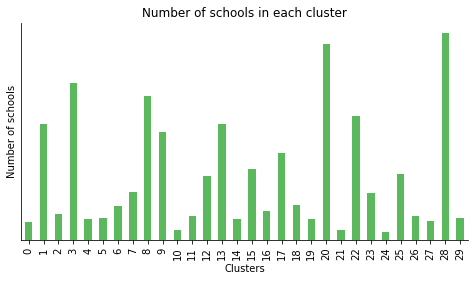

In [180]:
schools_cluster = london_schools['School_name'].groupby(london_schools['clusters']).count()

ax = schools_cluster.plot(kind='bar',
                         figsize=(8,4),
                         color = '#5cb85c',
                         fontsize = 10)
ax.set_title('Number of schools in each cluster')
ax.set_xlabel('Clusters')
ax.set_ylabel('Number of schools')
ax.tick_params(top=False, left=False, right=False, labelleft=False)

for sides in ['right','top']:
    ax.spines[sides].set_visible(False)

Clusters 3,8,20 and 28 have the highest number of schools (significantly more than the other clusters) and therefore are preferred clusters.

In [195]:
# top clusters with most schools
schools_cluster.sort_values(ascending=False).nlargest(n=5)

clusters
28    129
20    122
3      98
8      90
22     77
Name: School_name, dtype: int64

In [196]:
preferred_list = london_schools[london_schools['clusters'].isin([28,20,3,8,22])]
preferred_list

,PostCode,Areas,Lat,Lng,School_check,School_name,School_category,clusters
27,EC1,Aldersgate,51.520150,-0.098683,1,City of London School for Girls,High School,3
37,EC1,Aldersgate,51.520150,-0.098683,1,Prior Weston School,School,3
38,EC1,Aldersgate,51.520150,-0.098683,1,Dallington School,School,3
45,EC3,Aldgate,51.514248,-0.075719,1,Sir John Cass Primary School,Elementary School,3
48,EC3,Aldgate,51.514248,-0.075719,1,English Martyrs Catholic Primary School,School,3
...,...,...,...,...,...,...,...,...
3355,W12,White City,51.511935,-0.224236,1,St. Francis Of Assisi Catholic Primary School,Elementary School,20
3357,E1,Whitechapel,51.518623,-0.062081,1,Swanlea School,School,3
3358,E1,Whitechapel,51.518623,-0.062081,1,Osmani Primary School,School,3
3362,E1,Whitechapel,51.518623,-0.062081,1,Harry Gosling Primary School,Elementary School,3


In [229]:
# visualise these schools with cluster colours
latitude_p = preferred_list.Lat.mean()
longitude_p = preferred_list.Lng.mean()
map_preferred_list = folium.Map(location=[latitude_p,longitude_p], tiles='Stamen Toner', zoom_start=12)

from matplotlib import colors

# format colour for each cluster
x = np.arange(k)
ys = [i+x+(i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0,1,len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers
for lat, lng, school, category, cluster in zip(preferred_list.Lat, preferred_list.Lng, preferred_list.School_name, preferred_list.School_category, preferred_list.clusters):
    label = '{}, cluster {}, school type: {}'.format(school, cluster, category)
    label = folium.Popup(label, parse_html=True)
    folium.features.CircleMarker(
        [lat,lng],
        radius = 5,
        color = rainbow[cluster-1],
        fill = True,
        popup = label,
        fill_color = rainbow[cluster-1],
        fill_opacity = 0.6,
        parse_html=False
    ).add_to(map_preferred_list)
    
map_preferred_list

## Section D: Results

From the above data analysis, we have concluded that it is most optimal to cluster all postal areas in Greater London into 30 clusters.
Although not all postal areas in London have schools within the area, there is always a school nearby, i.e. within the same geographic cluster.

Among the 30 clusters, we have focused on only the availabilities / choice of pre-college education institutions. Non relevant categories such as pet schools are excldued. Also universities and colleges are excluded as one typically lives away from home when they go to college/universities.

As a result, we have selected top five clusters with the highest number of schools compared to the other clusters as our preferred clusters.

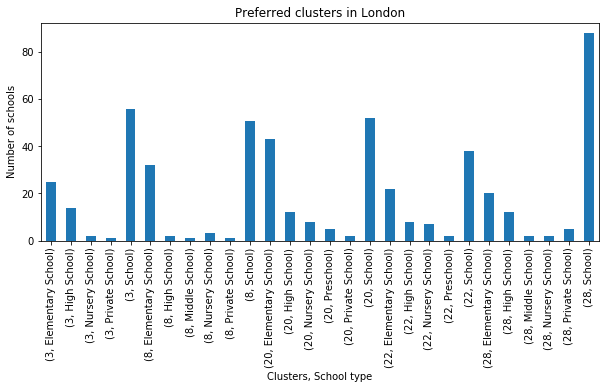

In [253]:
grouped = preferred_list['School_name'].groupby([preferred_list['clusters'],preferred_list['School_category']]).count()
grouped.plot(kind='bar', figsize=(10,4))
plt.title('Preferred clusters in London')
plt.xlabel('Clusters, School type')
plt.ylabel('Number of schools')
plt.show()

## Section E: Discussions

From the graph in the result section, we can see that clusters 8 and 28 seem to have greater variety are more equally distributed types of schools compared to the other clusters. In other words, although all clusters seem to have greater number of primary schools, clusters 8 and 28 also have a descent number of middle/high schools which enables families to live in the area for longer as their kids grow older.

Therefore these neighbourhoods are likely to be more favoured by families considering medium to long term settlement. We could therefore narrowing our recommendation further to areas within clusters 8 and 28 - listed below:

In [254]:
recommended_areas = preferred_list[preferred_list['clusters'].isin([8,28])].loc[:,['PostCode','Areas']].drop_duplicates().reset_index(drop=True)
recommended_areas

,PostCode,Areas
0,WC2,Aldwych
1,N22,Alexandra Park
2,E14,All Saints
3,EC1,Angel
4,N19,Archway
...,...,...
75,W9,Warwick Park
76,SE1,Waterloo
77,SW1,Westminster
78,SW1A,Westminster Abbey


## Section F: Conclusion / potential further work

This analysis identified 55 postal areas in Greater London that can be preferred areas for young families considering medium to long term settlment.
This is based on the assumption that this type of families would prefer areas offering great pre-college education options for their children.
Given this type of families are the main target buyers for the residential development project. It is recommended that the building should ideally locate in these postal areas.


Further work:

While school availabilites is an important consideration for most young families, other factors can also be key, e.g. local crime rate, transport connectivity, pollution level etc. The next phase of this project should include analysis on these additional factors.